### Based on https://support.bioconductor.org/p/58553/ try to figure out how to model the equation appropriately in R.

The setup there was species, diet, and clone.  Clones are nested within species, so the design is not fully crossed.  Each clone is tested in both A and B diets, so that is a within-subjects factor.

A linear model of this could be (note, not modeled in the way we would see it in R- that comes below):

$Y_{ijk} = \mu + S_i + D_j + C(S)_{ik} + SD_{ij} + DC(S)_{ijk}$

where $Y_{ijk}$ is an outcome variable (e.g. gene expression), $\mu$ is an overall mean, $S_i$ indicates species $i$ ($i \in \{1,2\}$), $D_j$ indicates diet $j$ ($j \in \{1,2\}$), and $C(S)_{ik}$ indicates that clone $k$ ($k \in \{1,\ldots,5\}$) is nested inside species $i$.  The term we're most interested in here is $SD_{ij}$ which is the interaction of species $i$ with diet $j$.  The final term $DC(S)_{ijk}$ is the clone-specific effect of the diet.  Collectively, any term with $k$ represents some random error about the mean for the other combinations of species and diet factors.

Initially, ignore the paired nature of the clones (with respect to diet) and consider only the species and diet factors, leaving:

$Y_{ij} = \mu + S_i + D_j + SD_{ij}$

Setup some simulated data, and run the model in DESeq2 to see that we recover the result.

First, the experimental design:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
sns.set_style('darkgrid')

/home/brian/Python/venv/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# setup the design, including the clones, which are nested within the species factor.  Initially we will ignore
# but later we will incorporate.

species = np.repeat(['sp1','sp2'],10)
diet = np.tile(['A', 'B'], 10)
clone = ['c%s' % s for s in np.repeat(np.arange(1,11),2)]
design = pd.DataFrame({'species':species, 'diet': diet, 'clone':clone})
sample_ids = design.clone + '_' + design.diet + '_' + design.species
design.index = sample_ids
design

,clone,diet,species
c1_A_sp1,c1,A,sp1
c1_B_sp1,c1,B,sp1
c2_A_sp1,c2,A,sp1
c2_B_sp1,c2,B,sp1
c3_A_sp1,c3,A,sp1
c3_B_sp1,c3,B,sp1
c4_A_sp1,c4,A,sp1
c4_B_sp1,c4,B,sp1
c5_A_sp1,c5,A,sp1
c5_B_sp1,c5,B,sp1


### In the threads, they were interested in:
- comparison of diet
- comparison of species
- interaction of species with diet (i.e. does the diet affect the species differently).

This final effect is the one we wish to look at and see if we can recover from the simulated data.

First, we include both main effects of species and diet, AND include an interaction.  That is, species 1 values will be generally higher, and the response to the diet will be different between species 1 and 2.  Specifically, species 1 will increase with diet B, and species 2 will decrease with diet B.

If we model (using R formula syntax) as "~species + diet + species:diet" The model is:

$Y =\beta_0 + \beta_1 I(sp=2) + \beta_2I(diet=B) + \beta_3I(sp=2,diet=B)$

where the intercept term $\beta_0$ represents the mean of expressions of samples from species 1 on diet A.  The indicator function $I(sp=2)$ is 1 if the sample is species 2 and zero for species 1.  Similar for the other indicators.

### First make some simulated data and plot to show the structure:

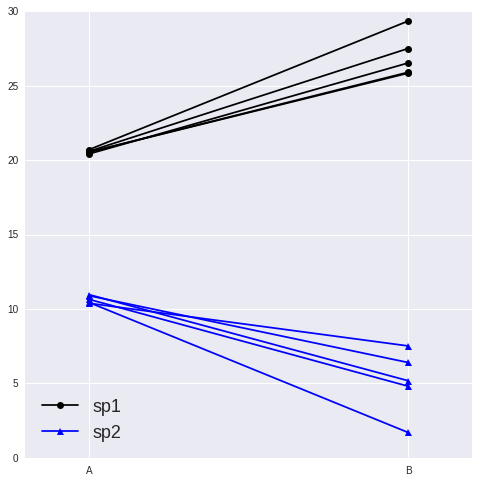

In [47]:
np.random.seed(0)
z0 = 10 # some value, doesn't matter except to change the 
d = 1

# sample all data from a uniform distribution to start.  
# only set the values in the 'A' condition
#THEN we will add the main and interaction effects.
data = pd.Series(index=design.index)
data[design.index] = 0
a_samples = [x for x in design.index if x.split('_')[1] == 'A']
data[a_samples] = z0+d*np.random.random(size=10)

# now to add the interaction effect.
# here, we mock species 1 having a positive effect associated with the diet change (A->B)
# and species 2 having a negative effect.
delta = 5.0 # mean of a normal distribution
scale = delta/2 # stdev of the normal

#perturb the sp1 value UP in the B diet:
# take the 
start_index = design.ix[(design.species == 'sp1') & (design.diet == 'A')].index
target_index = map(lambda x: x.replace('_A_','_B_'), start_index)
data[target_index] = data[start_index] + np.random.normal(loc = delta, scale=scale, size=5)

#perturb the sp2 value DOWN in the B diet:
start_index = design.ix[(design.species == 'sp2') & (design.diet == 'A')].index
target_index = map(lambda x: x.replace('_A_','_B_'), start_index)
data[target_index] = data[start_index] - np.random.normal(loc = delta, scale=scale, size=5)
data.name = 'mygene'


# add a main effect for species:
main_species_effect_size = 10
target_index = design.ix[design.species == 'sp1'].index
data[target_index] = data[target_index] + main_species_effect_size

# plot the pairs to confirm our simulated data:
fig, ax = plt.subplots(figsize=(8,8))

for clone_id in ['c%s' % x for x in np.arange(1,6)]:
        diet_a = clone_id + '_A_sp1'
        diet_b = clone_id + '_B_sp1'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-o', c='k', label='sp1')

for clone_id in ['c%s' % x for x in np.arange(6,11)]:
        diet_a = clone_id + '_A_sp2'
        diet_b = clone_id + '_B_sp2'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-^', c='b', label='sp2')
ax.set_xticks([0,1])
ax.set_xticklabels(['A', 'B'])
ax.set_xlim(-0.2, 1.2)
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
plt.legend(newHandles, newLabels, loc=3, fontsize=18)
plt.show()


With this data and the following model,

$Y =\beta_0 + \beta_1 I(sp=2) + \beta_2I(diet=B) + \beta_3I(sp=2,diet=B)$

Comparing the model for (species 1, diet A) with (species 1, diet B):

$Y_{1,A} =\beta_0$

$Y_{1,B} = \beta_0 + \beta_2$

we see that the main effect of condition, $\beta_2$, is controlled by the upper line (species 1).  By visual inspection, this is maybe 6 or so.

Comparing the models for (species 1, diet A) with (species 2, diet A) to get the species main effect:

$Y_{1,A} =\beta_0$

$Y_{2,A} = \beta_0 + \beta_1$

We see that $\beta_1$ is the difference on the left side (diet A).  This appears to be about -10.

Finally, the interaction term $\beta_3$ can be expressed as:

$\beta_3 = Y_{2,B} - \beta_0 - \beta_1-\beta_2$

identifying $Y_{2,A} = \beta_0 + \beta_1$, we can write

$\beta_3 = Y_{2,B} - Y_{2,A}-\beta_2$

From the plot, estimating $Y_{2,B} - Y_{2,A} \approx -5$ and $\beta_2 \approx 6$, this gives a guess of $\beta_3 \approx -11$






### First, run a simple linear model so confirm that it's capable of finding our known main/interaction effects.

I didn't want to get involved with rpy2 here, so just use the linear model functionality in statsmodels.

In [20]:
import statsmodels.formula.api as sm

In [48]:
# create a dataframe with the d.v. and design matrix:
df = pd.DataFrame(np.floor(data))
df = df.astype(int)
full_df = pd.concat([design, df], axis=1)
full_df.to_csv('fake_data.tsv', index_label='sample', sep='\t')
print full_df
print '=*'*50

model = sm.ols(formula='mygene ~ species + diet + species:diet', data=full_df)
results = model.fit()
print results.summary()

          clone diet species  mygene
c1_A_sp1     c1    A     sp1      20
c1_B_sp1     c1    B     sp1      25
c2_A_sp1     c2    A     sp1      20
c2_B_sp1     c2    B     sp1      29
c3_A_sp1     c3    A     sp1      20
c3_B_sp1     c3    B     sp1      27
c4_A_sp1     c4    A     sp1      20
c4_B_sp1     c4    B     sp1      25
c5_A_sp1     c5    A     sp1      20
c5_B_sp1     c5    B     sp1      26
c6_A_sp2     c6    A     sp2      10
c6_B_sp2     c6    B     sp2       4
c7_A_sp2     c7    A     sp2      10
c7_B_sp2     c7    B     sp2       1
c8_A_sp2     c8    A     sp2      10
c8_B_sp2     c8    B     sp2       6
c9_A_sp2     c9    A     sp2      10
c9_B_sp2     c9    B     sp2       5
c10_A_sp2   c10    A     sp2      10
c10_B_sp2   c10    B     sp2       7
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
                            OLS Regression Results                            
Dep. Variable:                 mygene   R-s

### Take a look at the parameters obtained from the fit:

In [49]:
results.params

Intercept                   20.0
species[T.sp2]             -10.0
diet[T.B]                    6.4
species[T.sp2]:diet[T.B]   -11.8
dtype: float64

### All of thoses parameters match our intuition and rough visual inspections.  Plot the regressions with the data:

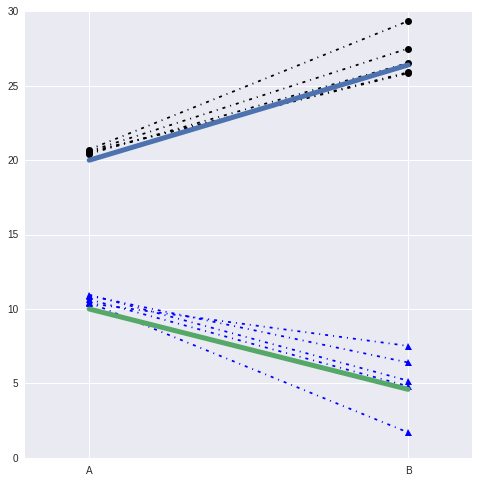

In [50]:
fig, ax = plt.subplots(figsize=(8,8))

for clone_id in ['c%s' % x for x in np.arange(1,6)]:
        diet_a = clone_id + '_A_sp1'
        diet_b = clone_id + '_B_sp1'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-.o', c='k')

for clone_id in ['c%s' % x for x in np.arange(6,11)]:
        diet_a = clone_id + '_A_sp2'
        diet_b = clone_id + '_B_sp2'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-.^', c='b')

        
# plot from the model fit:
B = results.params
ax.plot([0,1], [B[0], B[0]+B[2]], linewidth=5) # species 1:
ax.plot([0,1], [B[0]+B[1], B[0]+B[1]+B[2]+B[3]], linewidth=5) # species 2:

ax.set_xticks([0,1])
ax.set_xticklabels(['A', 'B'])
ax.set_xlim(-0.2, 1.2)
plt.show()
plt.close()

### Those look OK.

### Now embed this simulated data into a mocked count matrix, as provided by DESeq2.  Rather than dealing with rpy2, just call a Rscript, printed below.

In short, create a mock data matrix of 20 samples, and row-bind the data above to that matrix.  Then run the usual DESeq workflow and print out the results.  With rpy2, could simply import those results into this notebook, but for the moment we will have to copy the coefficients manually.

In [51]:
! cat make_mock_data.R

library(DESeq2)

args<-commandArgs(TRUE)

mydata <- read.table(args[1], sep='\t', header = T, row.names = 1, stringsAsFactors = F)

print(mydata)

mock_data <- makeExampleDESeqDataSet(m=20)
colnames(mock_data) = rownames(mydata)

mtx = counts(mock_data)
mtx = rbind(mtx, 'mygene'=mydata$mygene)

annotations = data.frame(species=factor(mydata$species), diet = factor(mydata$diet))
rownames(annotations) = rownames(mydata)

dds = DESeqDataSetFromMatrix(countData=mtx, colData=annotations, design=~species+diet + species:diet)
sizeFactors(dds) = rep(1,ncol(dds))
dds = DESeq(dds)

print(colData(dds))
print(resultsNames(dds))

print('Model coefficients, log2 scale:')
print(coef(dds)['mygene',])

print('Species effect:')
r1 = results(dds, contrast=c('species', 'sp2', 'sp1'))
print(r1['mygene',])

print('Diet effect:')
r2 = results(dds, contrast=c('diet', 'A', 'B'))
print(r2['mygene',])

print('Interaction:')
r3 = results(dds, contrast=c(0,0,0,1))
print(r3['mygene',])

write.table(counts(dds), 'mo

### Now actually run the script.  'fake_data.tsv' was created above when we ran the linear model via a python library.

In [52]:
! Rscript make_mock_data.R fake_data.tsv

Loading required package: S4Vectors
Loading required package: methods
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: IRanges
Loadin

### Reading off the model coefficients and copying below:

Note that the coefficients given from DESeq2 are on the log2 scale so have to raise to get the proper coefficients for plotting, etc.

In [53]:
log2coefs = np.array([4.3219278,         -0.9999998 ,         0.4005380  ,       -1.5208320])

### Plot the regressions using those coefficients

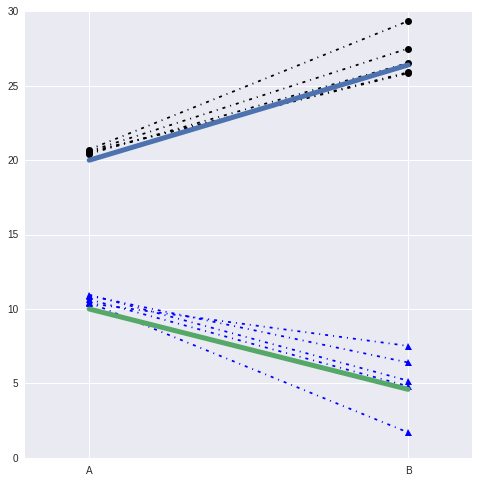

In [54]:
# plot the pairs to confirm our simulated data:
fig, ax = plt.subplots(figsize=(8,8))

for clone_id in ['c%s' % x for x in np.arange(1,6)]:
        diet_a = clone_id + '_A_sp1'
        diet_b = clone_id + '_B_sp1'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-.o', c='k')

for clone_id in ['c%s' % x for x in np.arange(6,11)]:
        diet_a = clone_id + '_A_sp2'
        diet_b = clone_id + '_B_sp2'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-.^', c='b')

        
# plot from the model fit:
B = log2coefs
ax.plot([0,1], [2**B[0], 2**(B[0]+B[2])], linewidth=5) # species 1:
ax.plot([0,1], [2**(B[0]+B[1]), 2**(B[0]+B[1]+B[2]+B[3])], linewidth=5) # species 2:

ax.set_xticks([0,1])
ax.set_xticklabels(['A', 'B'])
ax.set_xlim(-0.2, 1.2)
plt.show()
plt.close()

### So that looks pretty good as well.  I would expect better p/FDR-values based on the relative magnitude of the effect sizes and the dis

In [11]:
edger_coefs = [-7.587092, -6.945994e-01,  2.811711e-01,    -1.042682e+00]

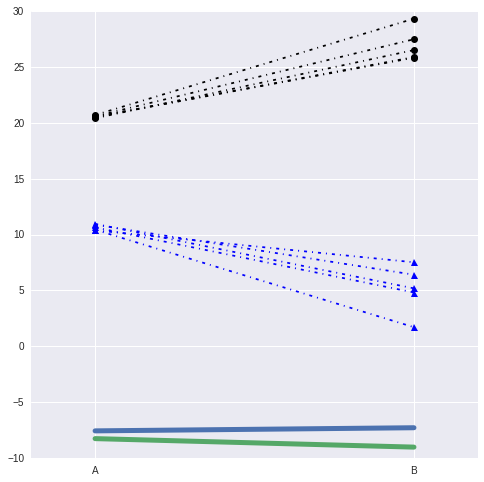

In [55]:
# plot the pairs to confirm our simulated data:
fig, ax = plt.subplots(figsize=(8,8))

for clone_id in ['c%s' % x for x in np.arange(1,6)]:
        diet_a = clone_id + '_A_sp1'
        diet_b = clone_id + '_B_sp1'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-.o', c='k')

for clone_id in ['c%s' % x for x in np.arange(6,11)]:
        diet_a = clone_id + '_A_sp2'
        diet_b = clone_id + '_B_sp2'
        v1 = data[diet_a]
        v2 = data[diet_b]
        ax.plot([0,1], [v1, v2], '-.^', c='b')

        
# plot from the model fit:
B = edger_coefs
ax.plot([0,1], [B[0], B[0]+B[2]], linewidth=5) # species 1:
ax.plot([0,1], [B[0]+B[1], B[0]+B[1]+B[2]+B[3]], linewidth=5) # species 2:

ax.set_xticks([0,1])
ax.set_xticklabels(['A', 'B'])
ax.set_xlim(-0.2, 1.2)
plt.show()
plt.close()